# Загрузка данных

Импорт и установка библиотек

In [ ]:
!pip install pmdarima
!pip install numpy==1.26.0
!pip install --upgrade tensorflow


import pickle
import warnings
import requests
import statsmodels
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from io import BytesIO
from datetime import datetime
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import acf, adfuller
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error


warnings.filterwarnings("ignore")
%matplotlib inline

Выберите способ загрузки данных

In [ ]:
url = "https://github.com/samoletpanfilov/reinforcement_task/raw/refs/heads/master/data/train.xlsx"  # Ссылка должна содержать raw
response = requests.get(url)
df_ts = pd.read_excel(BytesIO(response.content), engine='openpyxl')

In [ ]:
# df_ts = pd.read_excel('/content/drive/MyDrive/int/train.xlsx')

# Анализ и предобработка

### просмотр статистической информации

In [ ]:
df_ts.head(15)

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
5,2015-02-09,30300
6,2015-02-16,30100
7,2015-02-23,29400
8,2015-03-02,29200
9,2015-03-09,29000


In [ ]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


In [ ]:
# Проверка на наличие NaN
df_ts['dt'].isna().sum()

0

In [ ]:
df_ts.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


In [ ]:
df_ts.shape

(400, 2)

### Визуализация

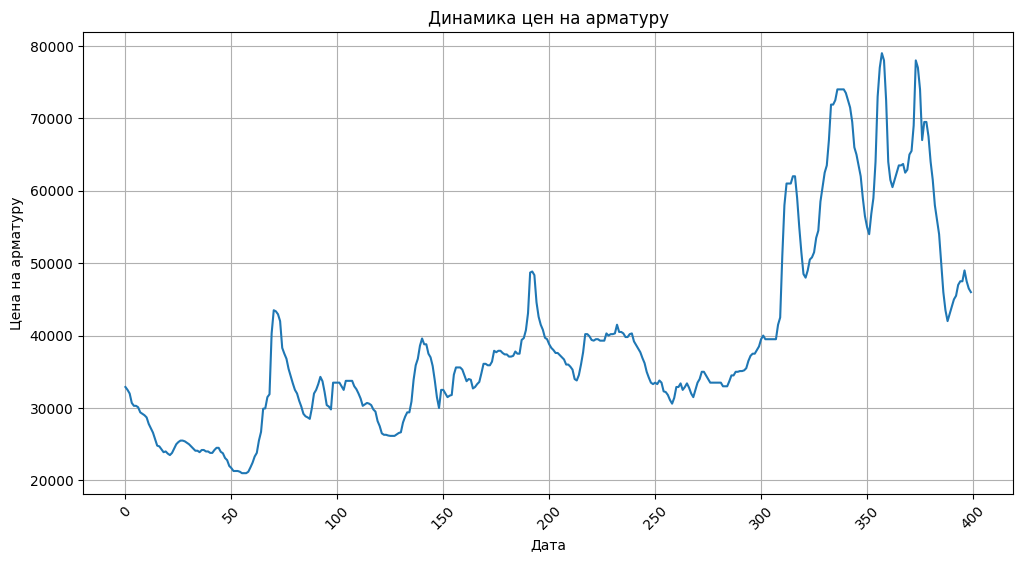

In [ ]:
# Строим график
plt.figure(figsize=(12, 6))
plt.plot(df_ts["Цена на арматуру"], marker='', linestyle='-')

# Настроим оси и заголовок
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Динамика цен на арматуру")
plt.grid(True)

# Улучшим читаемость меток дат
plt.xticks(rotation=45)

# Показываем график
plt.show()

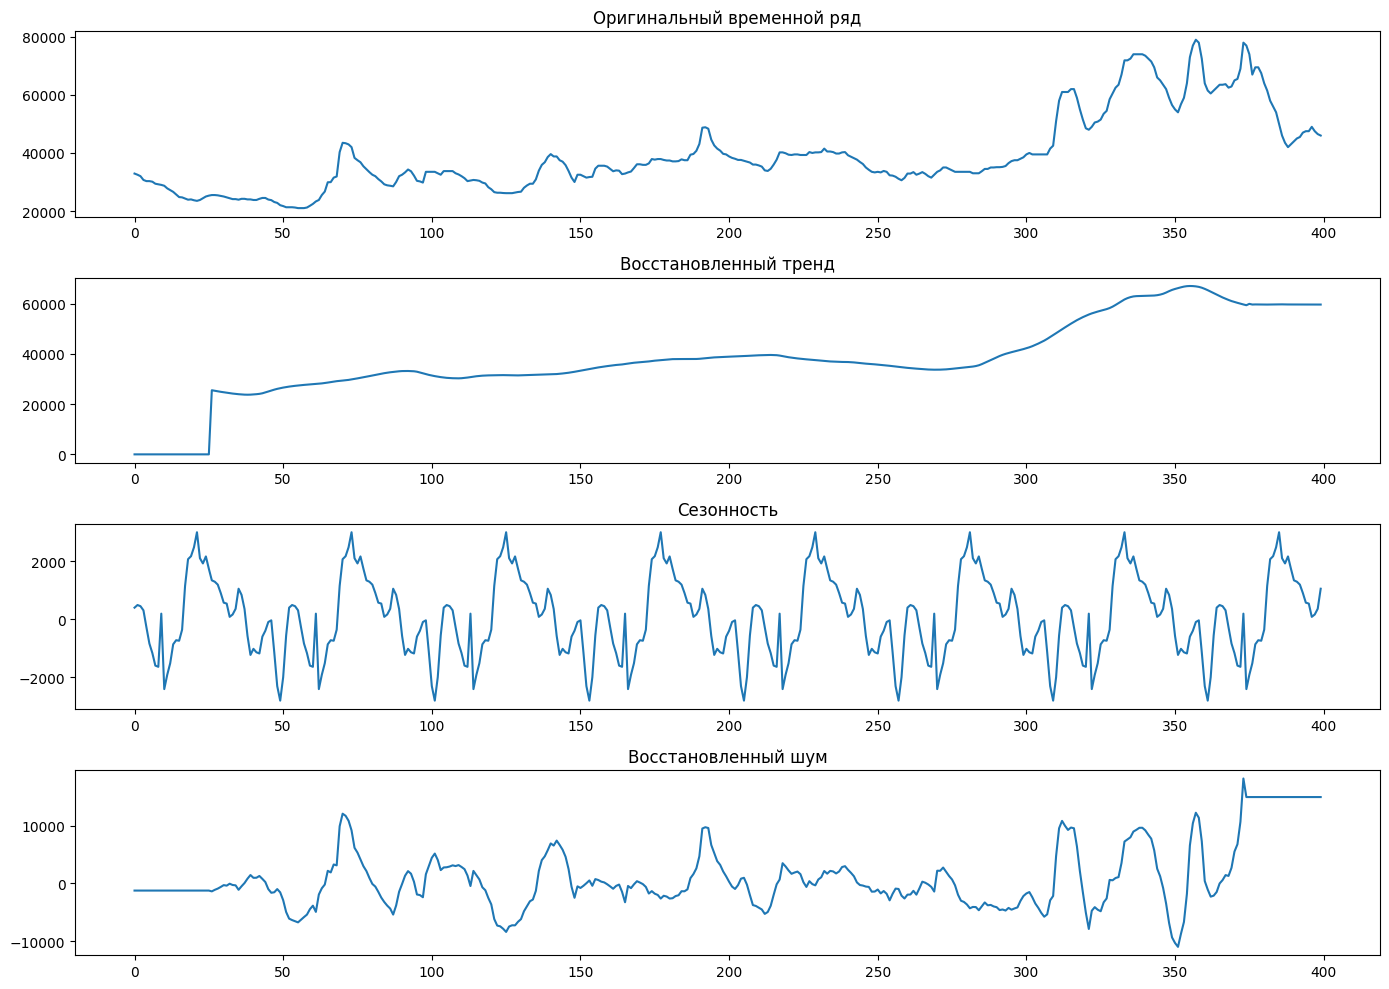

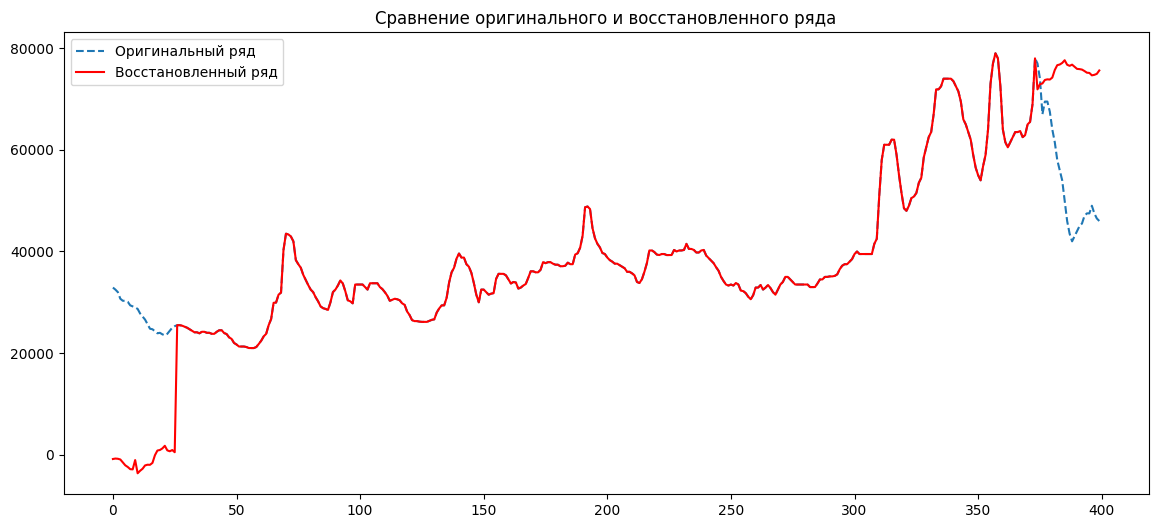

In [ ]:
# Декомпозиция временного ряда
decompose = seasonal_decompose(df_ts['Цена на арматуру'], period=52, extrapolate_trend=False)

# 1. Восстановление тренда с помощью SARIMA
trend_filled = decompose.trend.fillna(method='ffill')  # Заполняем пропуски временно, чтобы обучить модель
model_trend = SARIMAX(trend_filled, order=(5,2,0), seasonal_order=(0,0,1,52))
result_trend = model_trend.fit()

# Предсказание тренда на весь диапазон данных
trend_pred = result_trend.predict(start=trend_filled.index[0], end=trend_filled.index[-1])

# Вставляем предсказанные значения вместо NaN
trend_recovered = decompose.trend.copy()
trend_recovered.loc[trend_recovered.isna()] = trend_pred[trend_recovered.isna()]

# 2. Восстановление шума с помощью RandomForest
residuals = decompose.resid.copy()

# Разделяем известные и пропущенные значения
known_idx = residuals.dropna().index
missing_idx = residuals[residuals.isna()].index

# Обучаем RandomForest на известных значениях шума
X_train = np.array(known_idx).reshape(-1, 1)
y_train = residuals.dropna().values

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Восстанавливаем пропущенные значения
X_pred = np.array(missing_idx).reshape(-1, 1)
residuals.loc[missing_idx] = rf_model.predict(X_pred)

# 3. Восстановление полного временного ряда
df_ts['Восстановленный ряд'] = trend_recovered + decompose.seasonal + residuals

# 4. Визуализация
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 10))

# Оригинальный ряд
df_ts['Цена на арматуру'].plot(ax=axes[0], title='Оригинальный временной ряд')
# Восстановленный тренд
trend_recovered.plot(ax=axes[1], title='Восстановленный тренд')
# Сезонность (она неизменна)
decompose.seasonal.plot(ax=axes[2], title='Сезонность')
# Восстановленный шум
residuals.plot(ax=axes[3], title='Восстановленный шум')

plt.tight_layout()
plt.show()

# Сравнение оригинального и восстановленного ряда
plt.figure(figsize=(14,6))
plt.plot(df_ts['Цена на арматуру'], label="Оригинальный ряд", linestyle="dashed")
plt.plot(df_ts['Восстановленный ряд'], label="Восстановленный ряд", color='red')
plt.legend()
plt.title("Сравнение оригинального и восстановленного ряда")
plt.show()

### тест вариант

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from pmdarima import auto_arima
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV

# # Декомпозиция временного ряда
# decompose = seasonal_decompose(df_ts['Цена на арматуру'], period=52, extrapolate_trend=False)

# # 1. Восстановление тренда с помощью SARIMA
# trend_filled = trend_filled.fillna(method='ffill').fillna(method='bfill') # Заполняем пропуски временно, чтобы обучить модель

# # Подбор оптимальных параметров SARIMA
# auto_model = auto_arima(trend_filled, seasonal=True, m=52,
#                         stepwise=True, trace=True,
#                         suppress_warnings=True,
#                         error_action="ignore", max_order=20)

# # Используем найденные параметры
# best_order = auto_model.order
# best_seasonal_order = auto_model.seasonal_order

# # Обучаем SARIMA с лучшими параметрами
# model_trend = SARIMAX(trend_filled, order=best_order, seasonal_order=best_seasonal_order)
# result_trend = model_trend.fit()

# # Предсказание тренда
# trend_pred = result_trend.predict(start=trend_filled.index[0], end=trend_filled.index[-1])

# # Вставляем предсказанные значения вместо NaN
# trend_recovered = decompose.trend.copy()
# trend_recovered.loc[trend_recovered.isna()] = trend_pred[trend_recovered.isna()]

# # 2. Восстановление шума с помощью RandomForest
# residuals = decompose.resid.copy()

# # Разделяем известные и пропущенные значения
# known_idx = residuals.dropna().index
# missing_idx = residuals[residuals.isna()].index

# # Обучаем RandomForest на известных значениях шума
# X_train = np.array(known_idx).reshape(-1, 1)
# y_train = residuals.dropna().values

# # Подбор гиперпараметров RandomForest через GridSearchCV
# param_grid = {
#     "n_estimators": [50, 100, 200],
#     "max_depth": [10, 20, None],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 4],
# }

# rf_model = RandomForestRegressor(random_state=42)
# grid_search = GridSearchCV(rf_model, param_grid, cv=3, n_jobs=-1, verbose=1)
# grid_search.fit(X_train, y_train)

# # Используем лучшую модель
# best_rf_model = grid_search.best_estimator_

# # Восстанавливаем пропущенные значения
# X_pred = np.array(missing_idx).reshape(-1, 1)
# residuals.loc[missing_idx] = best_rf_model.predict(X_pred)

# # 3. Восстановление полного временного ряда
# df_ts['Восстановленный ряд'] = trend_recovered + decompose.seasonal + residuals

# # 4. Визуализация
# fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 10))

# # Оригинальный ряд
# df_ts['Цена на арматуру'].plot(ax=axes[0], title='Оригинальный временной ряд')
# # Восстановленный тренд
# trend_recovered.plot(ax=axes[1], title='Восстановленный тренд')
# # Сезонность (она неизменна)
# decompose.seasonal.plot(ax=axes[2], title='Сезонность')
# # Восстановленный шум
# residuals.plot(ax=axes[3], title='Восстановленный шум')

# plt.tight_layout()
# plt.show()

# # Сравнение оригинального и восстановленного ряда
# plt.figure(figsize=(14,6))
# plt.plot(df_ts['Цена на арматуру'], label="Оригинальный ряд", linestyle="dashed")
# plt.plot(df_ts['Восстановленный ряд'], label="Восстановленный ряд", color='red')
# plt.legend()
# plt.title("Сравнение оригинального и восстановленного ряда")
# plt.show()

In [ ]:
df_ts.head()

,dt,Цена на арматуру,Восстановленный ряд
0,2015-01-05,32900,-834.278846
1,2015-01-12,32500,-743.619505
2,2015-01-19,32000,-783.729396
3,2015-01-26,30700,-926.998626
4,2015-02-02,30300,-1510.707418


### Работа с автокорреляцией

In [ ]:
# Получил 'сырые' значения автокорреляций
acf(df_ts["Восстановленный ряд"] ,nlags = 100, fft = False)

array([1.        , 0.9829557 , 0.96245879, 0.93981617, 0.91648283,
       0.89340948, 0.87125865, 0.84985719, 0.82953466, 0.81013489,
       0.79192461, 0.77348073, 0.75599345, 0.73948378, 0.72411802,
       0.70914683, 0.6943273 , 0.67982237, 0.66475019, 0.64930649,
       0.63421322, 0.61920899, 0.60438107, 0.58897918, 0.5733525 ,
       0.55760069, 0.54156494, 0.53063092, 0.52193293, 0.51405683,
       0.50614573, 0.49876094, 0.49163962, 0.48455984, 0.47772507,
       0.47134514, 0.46547988, 0.46059827, 0.45637036, 0.45219542,
       0.44688496, 0.43850698, 0.42754647, 0.41530639, 0.40116421,
       0.38647535, 0.37309007, 0.36065093, 0.34849966, 0.33799457,
       0.32783257, 0.31790674, 0.30742493, 0.29638045, 0.28538032,
       0.27432431, 0.26327207, 0.25168555, 0.24003147, 0.22867041,
       0.21765264, 0.20662868, 0.19556251, 0.18397088, 0.1724885 ,
       0.16207865, 0.1528745 , 0.14362072, 0.13599359, 0.12943406,
       0.12553392, 0.12281751, 0.1203628 , 0.11795061, 0.11523

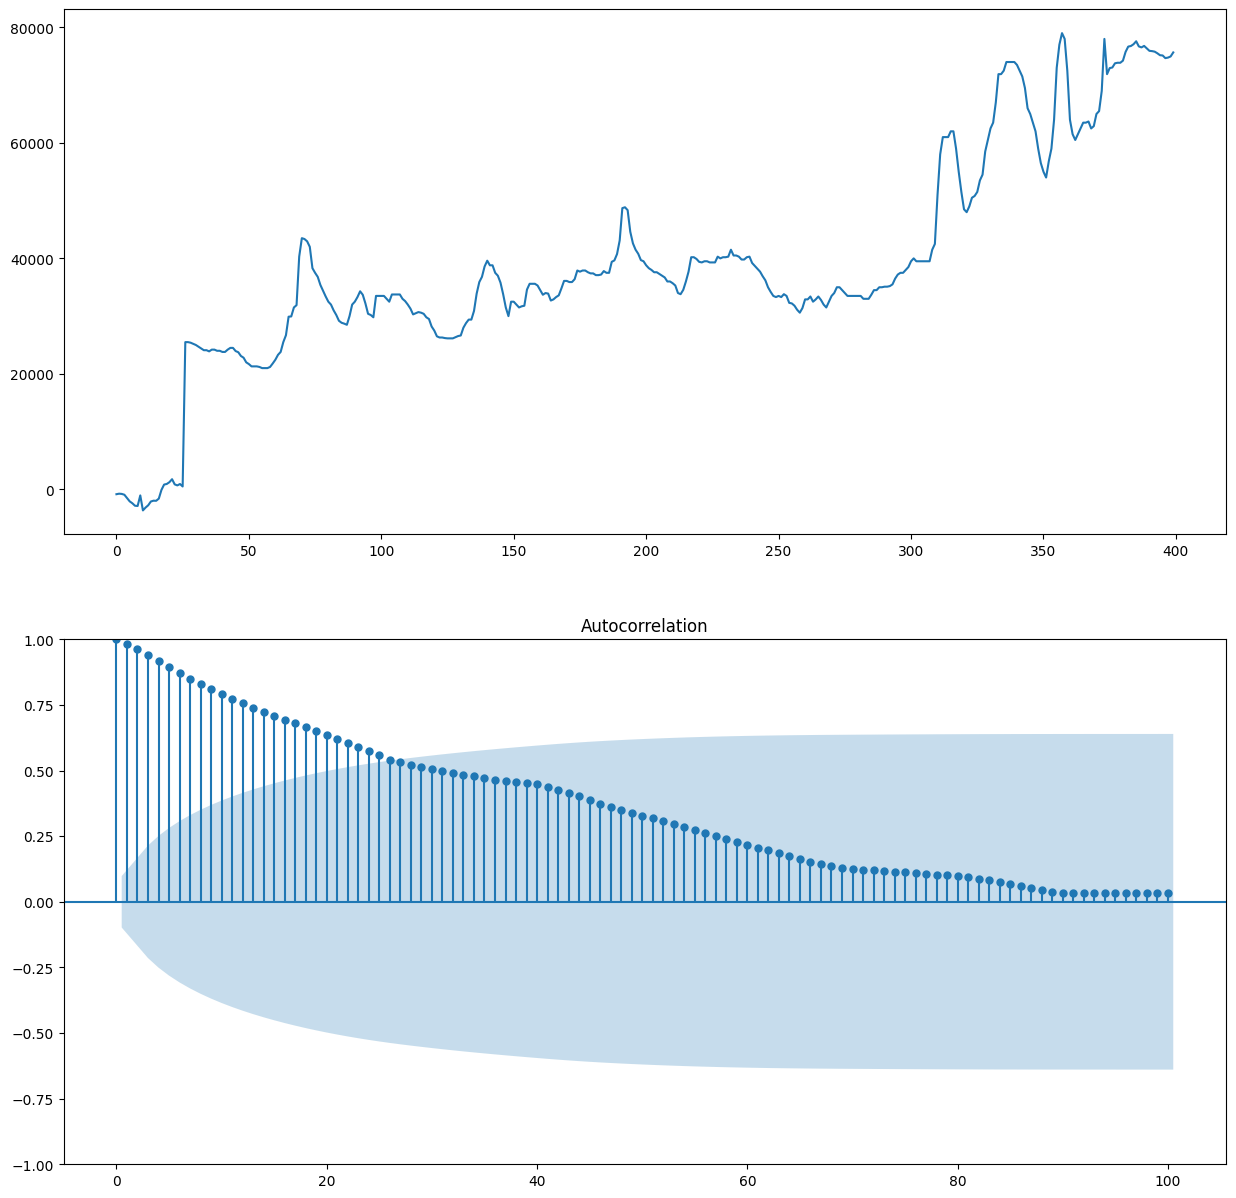

In [ ]:
# Визуализация автокорреляции

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
df_ts['Восстановленный ряд'].plot(ax=ax[0])
plot_acf(df_ts['Восстановленный ряд'], lags=100, ax=ax[1]);

In [ ]:
# проверка на стационарность первоначального ряда
# Функция для выполнения теста ADF
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    if result[1] < 0.05:
        print("Ряд стационарен (p-value < 0.05)")
    else:
        print("Ряд нестационарен (p-value >= 0.05)")
# Проверим на стационарность исходный ряд
adf_test(df_ts['Восстановленный ряд'])

ADF Statistic: -1.7686513025125759
p-value: 0.3961327253774738
Critical Values: {'1%': -3.4469295619737665, '5%': -2.8688478565083417, '10%': -2.570662885558566}
Ряд нестационарен (p-value >= 0.05)


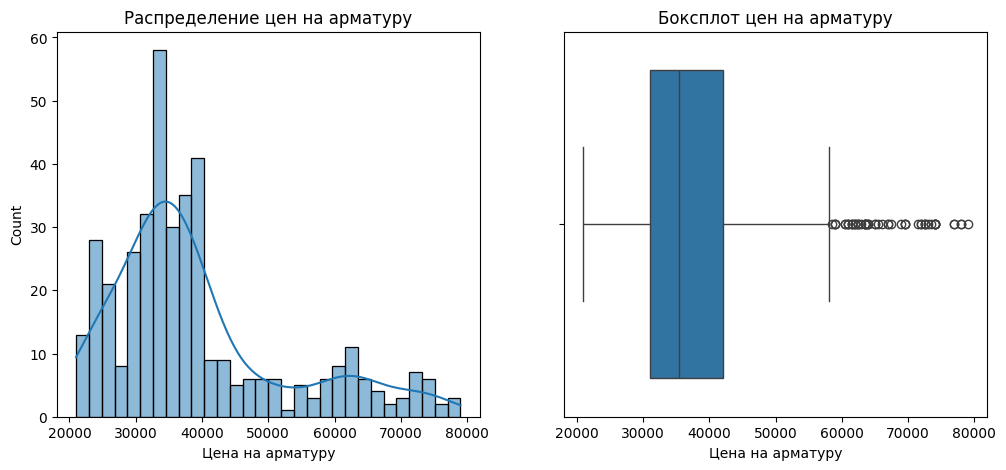

In [ ]:
plt.figure(figsize=(12, 5))

# Гистограмма
plt.subplot(1, 2, 1)
sns.histplot(df_ts["Цена на арматуру"], bins=30, kde=True)
plt.title("Распределение цен на арматуру")

# Боксплот
plt.subplot(1, 2, 2)
sns.boxplot(x=df_ts["Цена на арматуру"])
plt.title("Боксплот цен на арматуру")

plt.show()

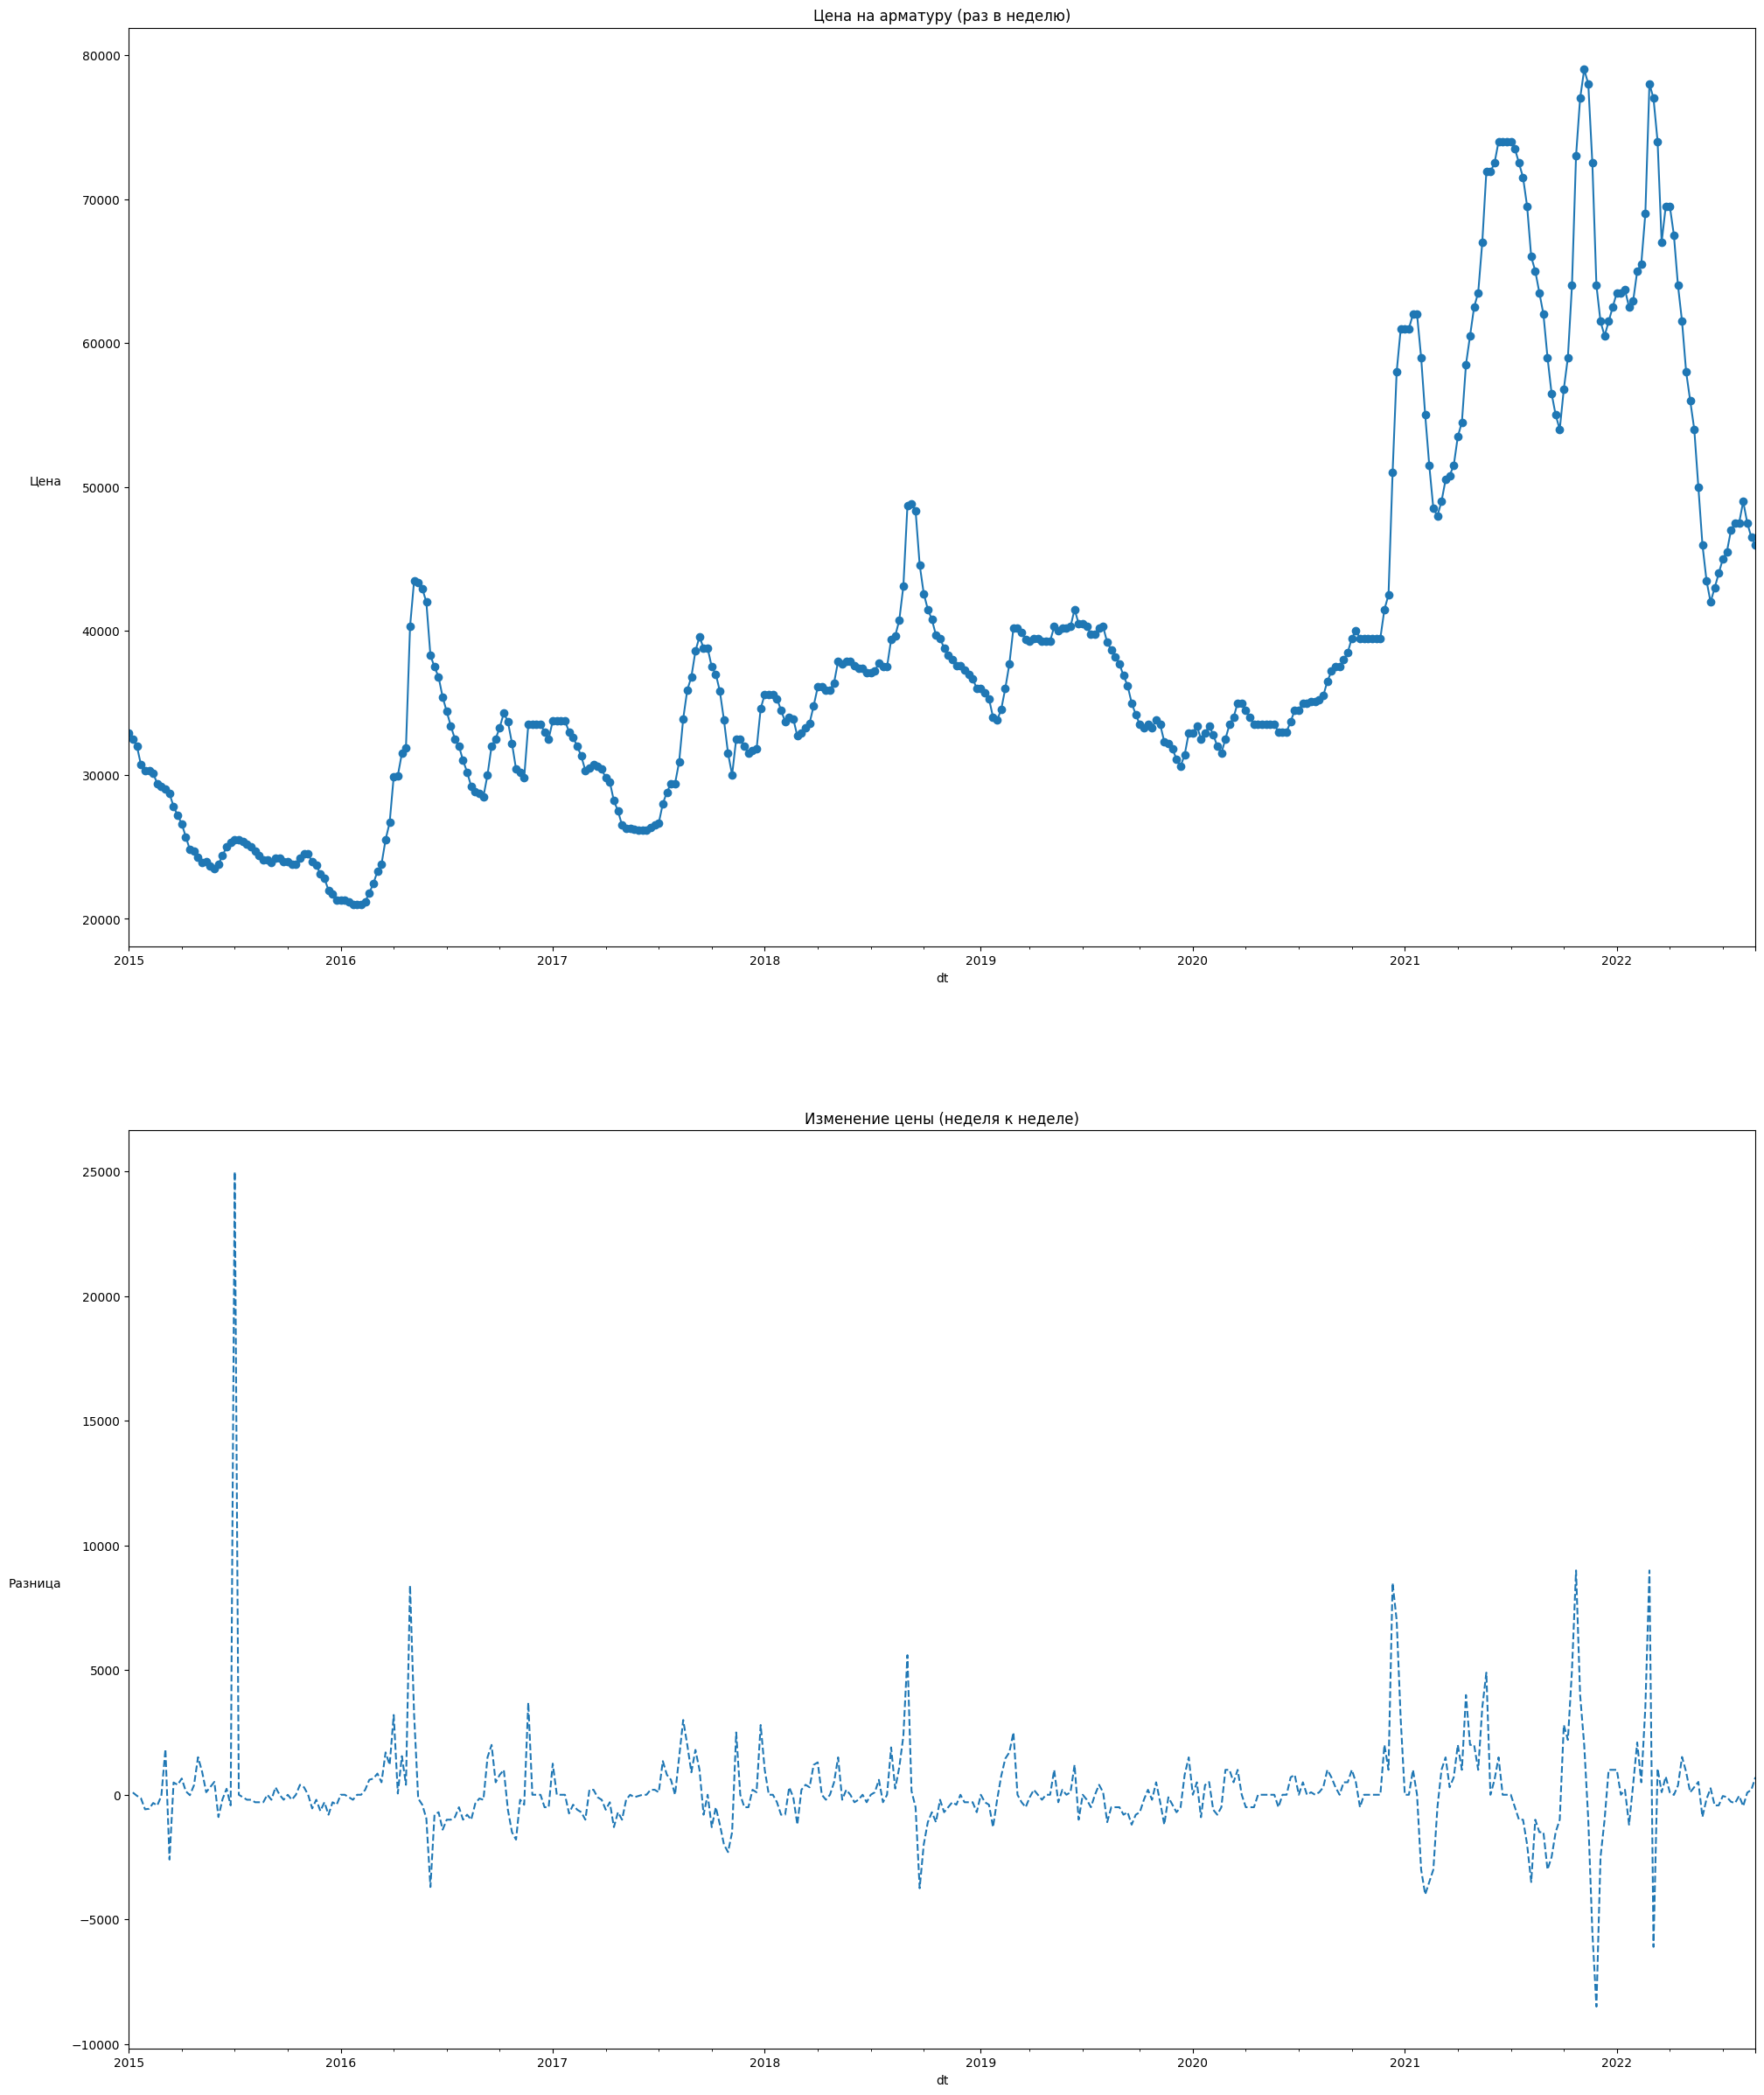

In [ ]:
df_ts['Цена_разница_неделя'] = df_ts['Восстановленный ряд'].diff(1)  # Разница с прошлой неделей

plt.figure(figsize=(24, 30))

ax1 = plt.subplot(211)
ax1.set_title('Цена на арматуру (раз в неделю)')
ax1.set_ylabel('Цена', rotation=0, labelpad=30)
df_ts.set_index('dt')['Цена на арматуру'].plot(ax=ax1, marker='o')

ax2 = plt.subplot(212)
ax2.set_title('Изменение цены (неделя к неделе)')
ax2.set_ylabel('Разница', rotation=0, labelpad=30)
df_ts.set_index('dt')['Цена_разница_неделя'].plot(ax=ax2, marker='', linestyle='dashed')

plt.show()

In [ ]:
df_ts.replace(np.nan, 0, inplace=True)

In [ ]:
df_ts.head(10)

,dt,Цена на арматуру,Восстановленный ряд,Цена_разница_неделя
0,2015-01-05,32900,-834.278846,0.000000
1,2015-01-12,32500,-743.619505,90.659341
2,2015-01-19,32000,-783.729396,-40.109890
3,2015-01-26,30700,-926.998626,-143.269231
4,2015-02-02,30300,-1510.707418,-583.708791
5,2015-02-09,30300,-2071.504121,-560.796703
6,2015-02-16,30100,-2400.899725,-329.395604
7,2015-02-23,29400,-2831.119505,-430.219780
8,2015-03-02,29200,-2872.603022,-41.483516
9,2015-03-09,29000,-1040.872253,1831.730769


In [ ]:
# проверка на стационарность diff ряда
# Функция для выполнения теста ADF
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    if result[1] < 0.05:
        print("Ряд стационарен (p-value < 0.05)")
    else:
        print("Ряд нестационарен (p-value >= 0.05)")
# Проверим на стационарность исходный ряд
adf_test(df_ts['Цена_разница_неделя'])

ADF Statistic: -10.780496289952545
p-value: 2.2617059804410594e-19
Critical Values: {'1%': -3.4468876315017423, '5%': -2.868829424528516, '10%': -2.570653059771218}
Ряд стационарен (p-value < 0.05)


In [ ]:
from scipy.signal import medfilt

df_ts["Цена на арматуру (сглаженная)"] = medfilt(df_ts["Цена_разница_неделя"], kernel_size=5)

In [ ]:
# проверка на стационарность diff ряда после сглаживания
# Функция для выполнения теста ADF
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    if result[1] < 0.05:
        print("Ряд стационарен (p-value < 0.05)")
    else:
        print("Ряд нестационарен (p-value >= 0.05)")
# Проверим на стационарность исходный ряд
adf_test(df_ts['Цена на арматуру (сглаженная)'])

ADF Statistic: -6.161370377384544
p-value: 7.160559707895835e-08
Critical Values: {'1%': -3.4474946672686824, '5%': -2.8690962436986855, '10%': -2.570795299750434}
Ряд стационарен (p-value < 0.05)


# Модели

In [ ]:
# 1. Нормализация данных для LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
df_ts["Цена на арматуру (сглаженная)"] = scaler.fit_transform(df_ts[["Цена на арматуру (сглаженная)"]])

# 2. Разделение данных
train_size = int(len(df_ts) * 0.8)
train, test = df_ts.iloc[:train_size].copy(), df_ts.iloc[train_size:].copy()

In [ ]:
def create_sequences(df_ts, target_column, seq_length, reshape_for_lstm=False):
    """
    Создает последовательности для временного ряда.

    :param df_ts: DataFrame с временным рядом.
    :param target_column: Название столбца с целевой переменной.
    :param seq_length: Длина окна (количество предыдущих точек для предсказания).
    :param reshape_for_lstm: Флаг, указывающий, нужно ли менять форму для LSTM.
    :return: Кортеж (X, y) с подготовленными выборками.
    """
    if target_column not in df_ts.columns:
        raise KeyError(f"Столбец '{target_column}' не найден в DataFrame!")

    X, y = [], []
    data = df_ts[target_column].values  # Берём нужный столбец как массив

    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # Формируем последовательность длины seq_length
        y.append(data[i + seq_length])  # Следующее значение как целевая переменная

    X, y = np.array(X), np.array(y)

    if reshape_for_lstm:
        X = X.reshape((X.shape[0], X.shape[1], 1))  # Преобразуем для LSTM (samples, timesteps, features)

    return X, y

# Пример использования
seq_length = 20
target_column = "Цена на арматуру (сглаженная)"

X_train, y_train = create_sequences(df_ts, target_column, seq_length, reshape_for_lstm=True)  # Для LSTM
X_test, y_test = create_sequences(df_ts, target_column, seq_length, reshape_for_lstm=True)  # Для LSTM
X_train_lr, y_train_lr = create_sequences(df_ts, target_column, seq_length, reshape_for_lstm=False)  # Для линейной регрессии
X_test_lr, y_test_lr = create_sequences(df_ts, target_column, seq_length, reshape_for_lstm=False)  # Для линейной регрессии

### Линейная регрессия

Средняя абсолютная ошибка (MAE): 0.04
Среднеквадратичная ошибка (MSE): 0.00
Корень среднеквадратичной ошибки (RMSE): 0.06
Коэффициент детерминации (R²): 0.8148
Коэффициент (наклон линии): 0.0388
Свободный член (пересечение с осью Y): 0.17


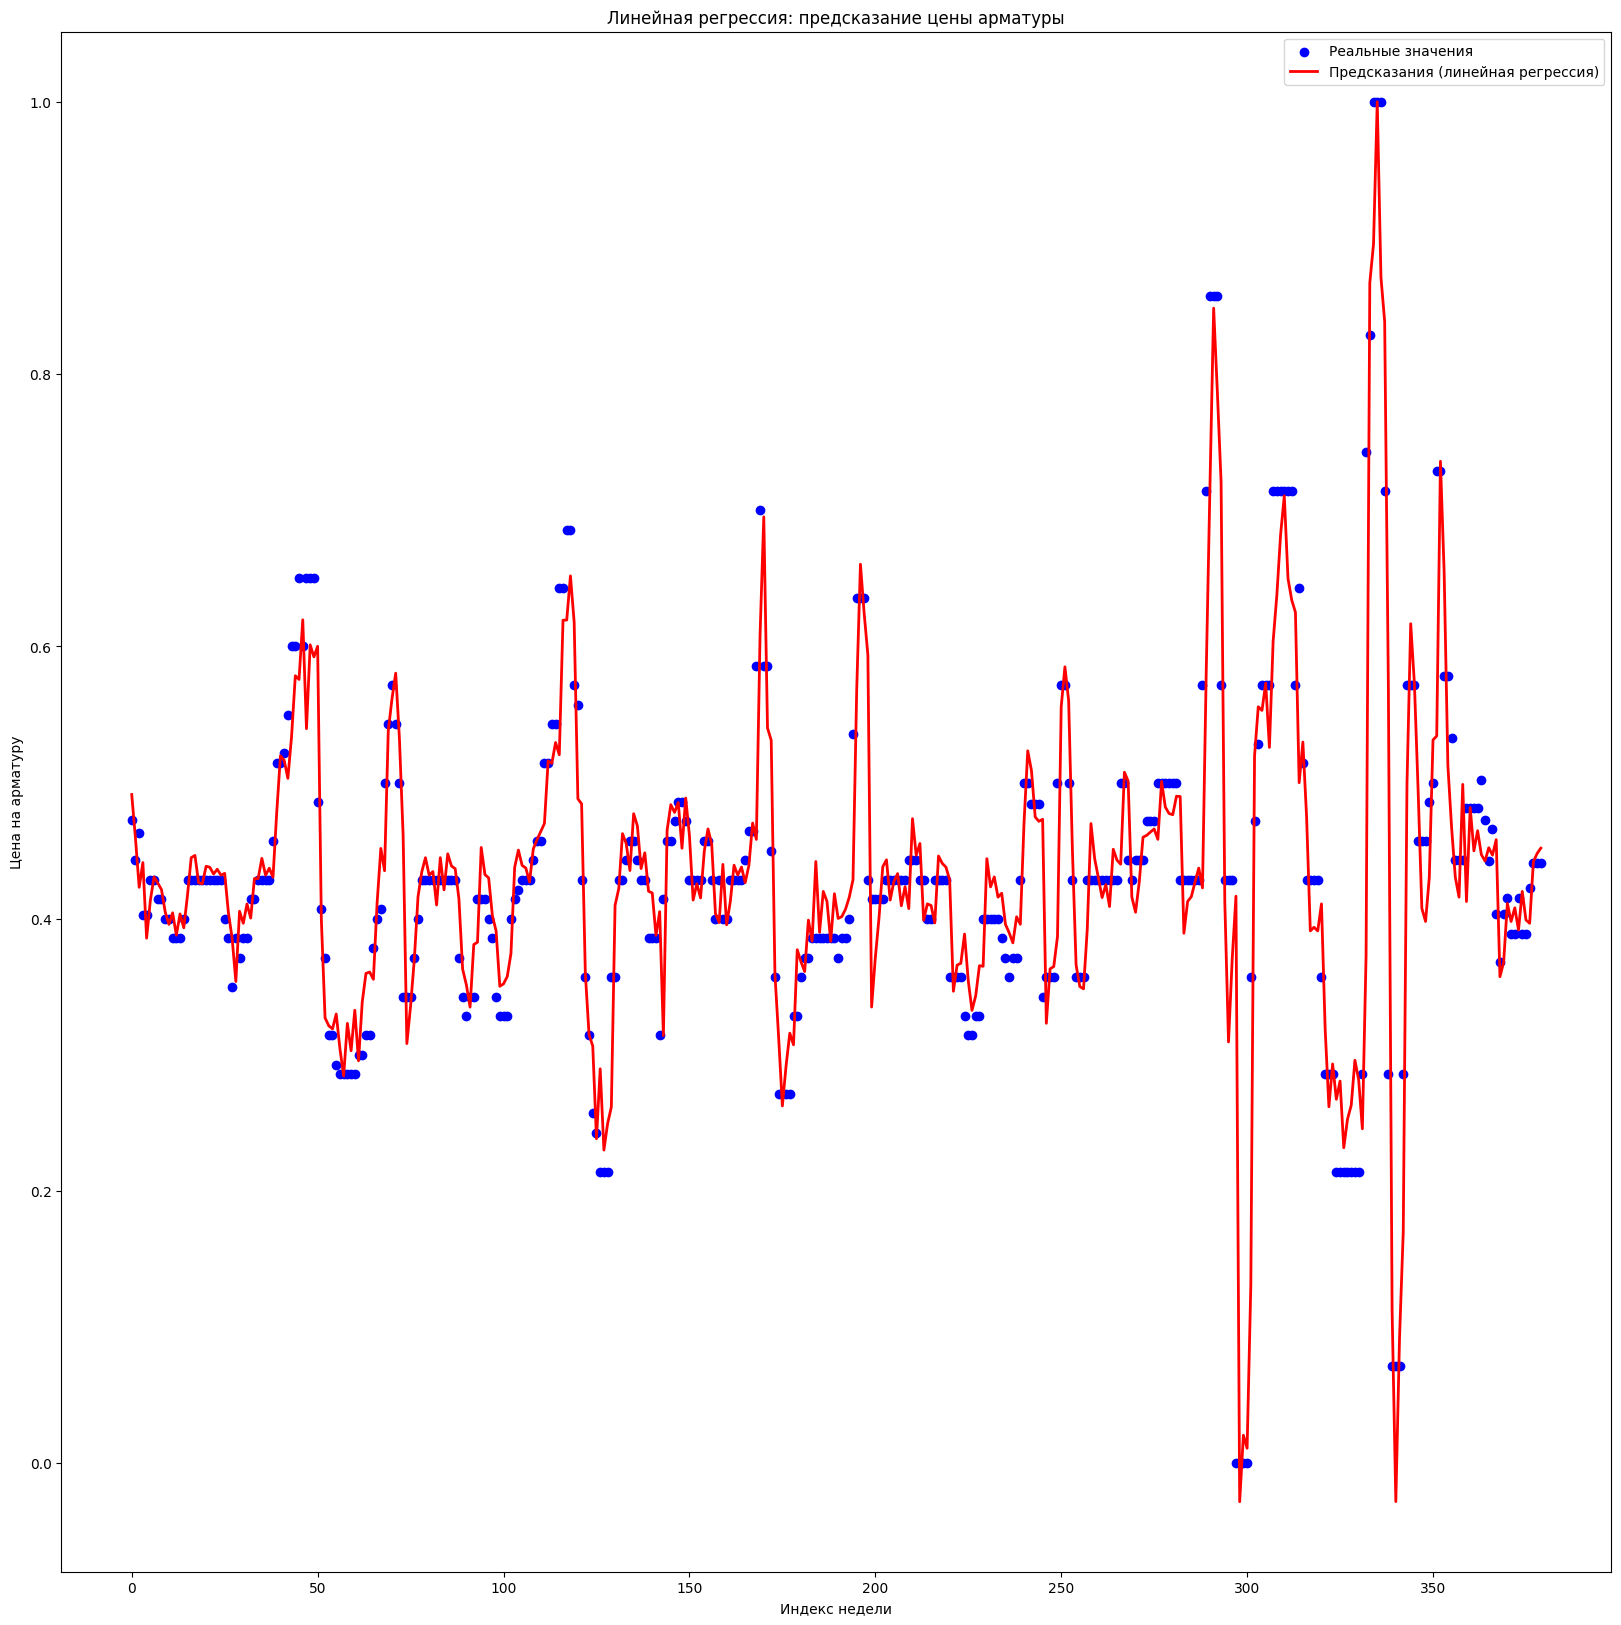

In [ ]:


# 5. Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train_lr, y_train_lr)

# 6. Получение предсказаний
y_pred = model.predict(X_test_lr)

# 7. Оценка качества модели
mae = mean_absolute_error(y_test_lr, y_pred)
mse = mean_squared_error(y_test_lr, y_pred)
rmse = np.sqrt(mse)
r2_score = model.score(X_test_lr, y_test_lr)

# Вывод метрик
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse:.2f}")
print(f"Коэффициент детерминации (R²): {r2_score:.4f}")

# 8. Вывод коэффициентов модели
print(f"Коэффициент (наклон линии): {model.coef_[0]:.4f}")
print(f"Свободный член (пересечение с осью Y): {model.intercept_:.2f}")

# 9. Визуализация результатов
plt.figure(figsize=(20, 20))

# Используем range(len(y_test_lr)) вместо X_test_lr для корректного отображения точек
plt.scatter(range(len(y_test_lr)), y_test_lr, color="blue", label="Реальные значения")
plt.plot(range(len(y_pred)), y_pred, color="red", linewidth=2, label="Предсказания (линейная регрессия)")

plt.xlabel("Индекс недели")
plt.ylabel("Цена на арматуру")
plt.title("Линейная регрессия: предсказание цены арматуры")
plt.legend()
plt.show()


### Arima

In [ ]:
!pip install --upgrade statsmodels

In [ ]:
from statsmodels.tsa.arima_model import ARIMA  # Для старых версий

In [ ]:
# Проверяем, есть ли NaN значения в тренировочных данных
print(f"Количество NaN в тренировочных данных: {df_ts.isna().sum()}")

# Если NaN значения есть, удаляем их
train_clean = df_ts.dropna()

# Проверяем снова, что NaN значения удалены
print(f"Количество NaN после удаления: {train_clean.isna().sum()}")
train_clean.head(10)

Количество NaN в тренировочных данных: dt                               0
Цена на арматуру                 0
Восстановленный ряд              0
Цена_разница_неделя              0
Цена на арматуру (сглаженная)    0
dtype: int64
Количество NaN после удаления: dt                               0
Цена на арматуру                 0
Восстановленный ряд              0
Цена_разница_неделя              0
Цена на арматуру (сглаженная)    0
dtype: int64


,dt,Цена на арматуру,Восстановленный ряд,Цена_разница_неделя,Цена на арматуру (сглаженная)
0,2015-01-05,32900,-834.278846,0.000000,0.428571
1,2015-01-12,32500,-743.619505,90.659341,0.428571
2,2015-01-19,32000,-783.729396,-40.109890,0.422841
3,2015-01-26,30700,-926.998626,-143.269231,0.408104
4,2015-02-02,30300,-1510.707418,-583.708791,0.381515
5,2015-02-09,30300,-2071.504121,-560.796703,0.367111
6,2015-02-16,30100,-2400.899725,-329.395604,0.367111
7,2015-02-23,29400,-2831.119505,-430.219780,0.381515
8,2015-03-02,29200,-2872.603022,-41.483516,0.381515
9,2015-03-09,29000,-1040.872253,1831.730769,0.422645


In [ ]:
# Выбираем столбец с данными временного ряда
from statsmodels.tsa.arima.model import ARIMA

# Выбираем столбец с данными временного ряда
time_series = df_ts['Цена на арматуру (сглаженная)']

# Создаем модель ARIMA с порядком (4, 0, 3)
model = ARIMA(time_series, order=(4, 0, 3))

# Обучаем модель
fitted_model = model.fit()

# Выводим результаты
print(fitted_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:     Цена на арматуру (сглаженная)   No. Observations:                  400
Model:                            ARIMA(4, 0, 3)   Log Likelihood                 575.337
Date:                           Wed, 19 Mar 2025   AIC                          -1132.673
Time:                                   21:09:32   BIC                          -1096.750
Sample:                                        0   HQIC                         -1118.447
                                           - 400                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4380      0.014     30.308      0.000       0.410       0.466
ar.L1          1.2326      0.246      5.017

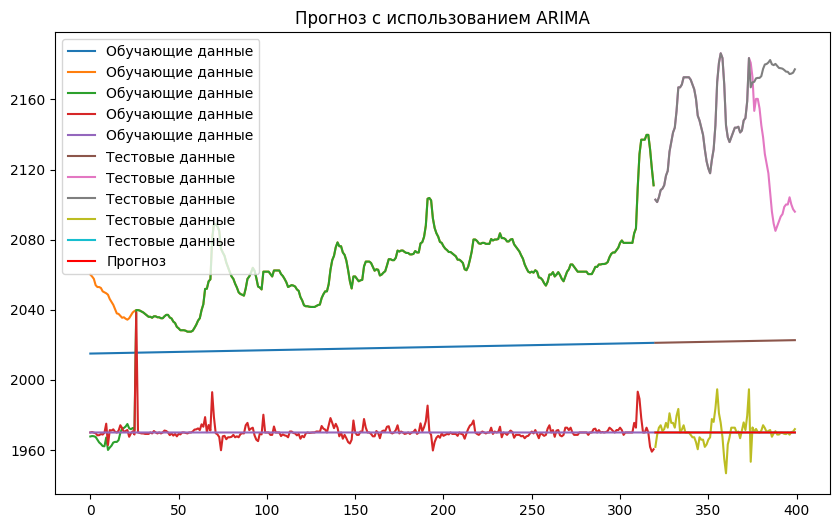

In [ ]:
# Прогнозируем на тестовых данных
forecast = fitted_model.predict(start=len(train), end=len(train) + len(test) - 1)

# Визуализируем результат
plt.figure(figsize=(10, 6))
plt.plot(train, label='Обучающие данные')
plt.plot(test, label='Тестовые данные')
plt.plot(forecast, label='Прогноз', color='red')
plt.legend()
plt.title('Прогноз с использованием ARIMA')
plt.show()


### LSTM

In [ ]:
# 5. Создание и обучение LSTM-модели

# Построение модели LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Компиляция модели
model.compile(optimizer="adam", loss="mse")

# Обучение модели
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - loss: 0.1040 - val_loss: 0.0238
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0246 - val_loss: 0.0203
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0190 - val_loss: 0.0177
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0204 - val_loss: 0.0175
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0186 - val_loss: 0.0167
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0173 - val_loss: 0.0161
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0187 - val_loss: 0.0155
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0156 - val_loss: 0.0149
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0136 - val_loss: 0.0142
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0161 - val_loss: 0.0133
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0138 - val_loss: 0.0120
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
MAE: 270.01
RMSE: 432.90
Общая длина df_ts: 400
train_size: 320, seq_length: 20
Длина df_ts после train_size + seq_length: 60
Размер y_test_inv: (380, 1)
Размер y_pred_inv: (380, 1)
Последние 10 дат в df_ts:
390   2022-06-27
391   2022-07-04
392   2022-07-11
393   2022-07-18
394   2022-07-25
395   2022-08-01
396   2022-08-08
397   2022-08-15
398   2022-08-22
399   2022-08-29
Name: dt, dtype: datetime64[ns]
Первые 10 дат тестового набора:
340   2021-07-12
341   2021-07-19
342   2021-07-26
343   2021-08-02
344   2021-08-09
345   2021-08-16
346   2021-08-23
347   2021-08-30
348   2021-09-06
349   2021-09-13
Name: dt, dtype: datetime64[ns]


ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

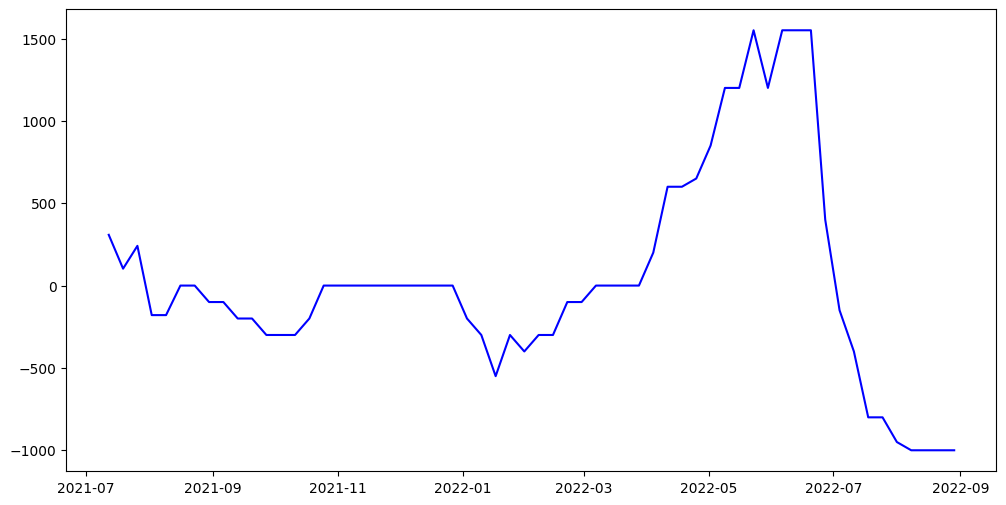

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Предсказания модели
y_pred = model.predict(X_test)

# Обратное масштабирование
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Оценка ошибок
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Проверка размеров данных
print(f"Общая длина df_ts: {len(df_ts)}")
print(f"train_size: {train_size}, seq_length: {seq_length}")
print(f"Длина df_ts после train_size + seq_length: {len(df_ts.iloc[train_size + seq_length:])}")
print(f"Размер y_test_inv: {y_test_inv.shape}")
print(f"Размер y_pred_inv: {y_pred_inv.shape}")

# Проверяем индексы временных меток
print("Последние 10 дат в df_ts:")
print(df_ts["dt"].tail(10))

print("Первые 10 дат тестового набора:")
print(df_ts["dt"].iloc[train_size + seq_length:train_size + seq_length + 10])

# Приведение размеров временных меток и предсказаний к общему минимуму
min_length = min(len(df_ts["dt"].iloc[train_size + seq_length:]), len(y_test_inv))
dates = df_ts["dt"].iloc[train_size + seq_length:train_size + seq_length + min_length]
y_test_inv = y_test_inv[:min_length].flatten()
y_pred_inv = y_pred_inv[:min_length].flatten()

# Разделяем даты и значения для фактических и прогнозных данных
split_index = len(y_test_inv)  # Последний индекс фактических данных
actual_dates = dates[:split_index]
forecast_dates = dates[split_index - 1:]  # Начинаем прогноз с последней фактической точки

actual_prices = y_test_inv[:split_index]
forecast_prices = np.concatenate([[actual_prices[-1]], y_pred_inv[split_index - 1:]])  # Начинаем с последней фактической цены

# Визуализация
plt.figure(figsize=(12, 6))

# Фактические данные (синяя линия)
plt.plot(actual_dates, actual_prices, label="Фактические цены", color="blue")

# Прогнозные данные (оранжевая линия, начиная с последней фактической точки)
plt.plot(forecast_dates, forecast_prices, label="Прогноз LSTM", color="orange", linestyle="dashed")

plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.legend()
plt.grid(True)
plt.show()


### смесь 2 моделй